### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (100 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $2000$ bootstrap realizations of this dataset. Using an appropriate timing function in python, how long did the generation of these realizations take? 
*DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together. This code will be graded on efficiency and speed; it should not take more than 1 second to execute.*

5) Repeat (2) with all $2000$ boostrap datasets to find the distribution of the sample mean. How long did this take? Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $2000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [47]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
import time

# MRS Load in the data
data = np.load('../../../homeworks/hw_data/hw3_data_1.npy')
vals = data[:,0]
uncert = data[:,1]


From Lecture we know

$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$



In [48]:
# MRS Calculating and printing the mean and sigma of the data
mean = np.sum(vals / uncert**2) / np.sum(1/uncert**2)
sig_mu = 1 / np.sqrt(np.sum(1/uncert**2))

print(mean, sig_mu)


4.082099776157917 0.0937975025520293


In this case we then have 

$${\rm lnL} = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma^2}.$$

In [113]:
# MRS Define the log-likelihood function of a gaussian distribution
def lnL(vals, uncert, mu):
    lnL = np.sum(-1/2 * np.log(2*np.pi*uncert**2)) - np.sum((vals - mu)**2/(2*uncert**2))
    return -1*lnL

# MRS lambda function for my log-likelihood
f_fit = lambda beta: lnL(vals, uncert, beta[0])

# MRS find the best mean value by optimizing the ln-likelihood function
beta0 = 4.0
beta_gauss = optimize.fmin(f_fit, beta0, full_output=True)
print("Best Fit Mean: ", beta_gauss[0][0])


Optimization terminated successfully.
         Current function value: 148.997180
         Iterations: 12
         Function evaluations: 24
Best Fit Mean:  3.9419921875000004


In [95]:
import numdifftools as nd

# MRS Calculating the fisher error using the Hessian
H = nd.Hessian(f_fit)(beta_gauss[0])
sigma_gauss = np.linalg.inv(H)**0.5

print(sigma_gauss[0])

[0.09313968]


In [51]:
# MRS Creating bootstrap function
def bootstrap(data, N):
    boot_samp = []
    
    for i in range(0, N):
        # MRS np.random.choice is a really cool function that I spent forever trying to reformat my data array to get to work for the resampling
        # MRS then my good colleguge Mr. GPT told me that its ok to just use an integer because it will sample indices from np.arange(a) if handed integer a. 
        temp = data[np.random.choice(len(data), size=len(data), replace=True)]  # Sample entire rows
        boot_samp.append(temp)

    return np.array(boot_samp)  

t0 = time.time()
# Run bootstrap
bootstrap_samples = bootstrap(data, 2000)

t1 = time.time()
print(f'Time take for N=2000 bootstrap: {t1 - t0:.3f}s')


Time take for N=2000 bootstrap: 0.021s


Time to calculate bet fit mean for all N bootstraps: 0.814s


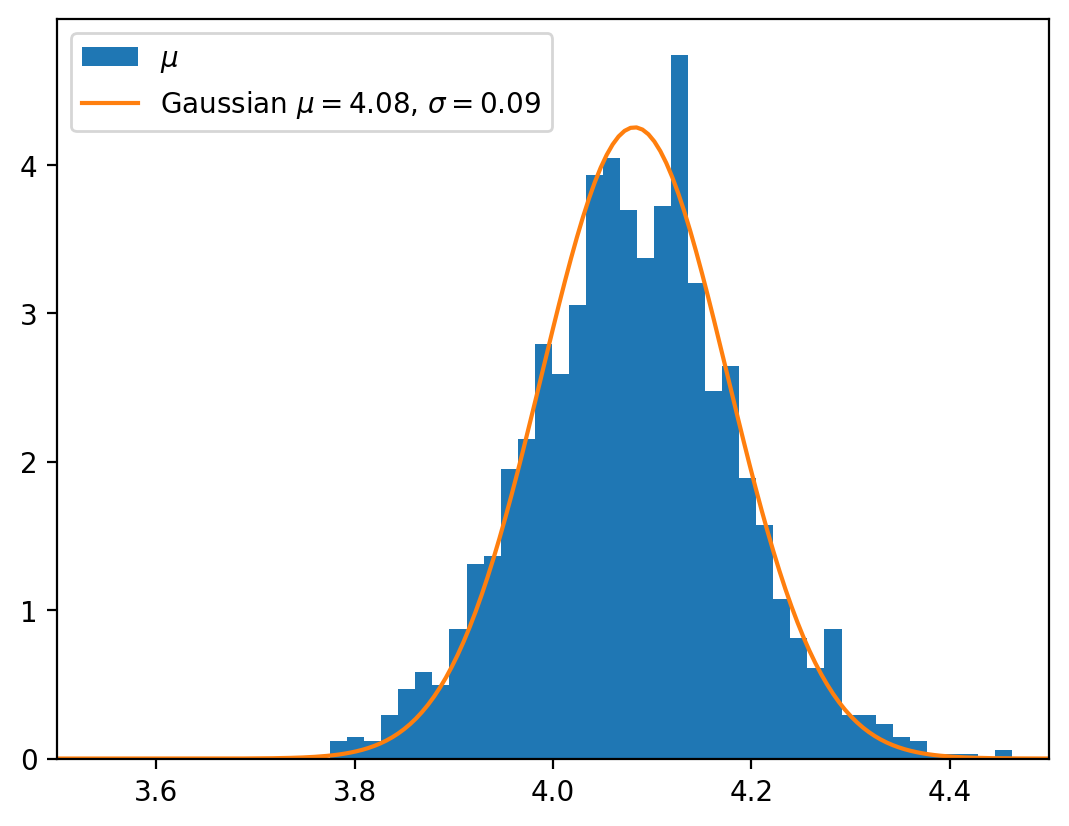

In [52]:
# MRS Defining a function to calcualte the best mu value for a given redrawn bootstrap sample
def calc_mu(vals, uncert):

    f_fit = lambda beta: lnL(vals, uncert, beta[0])
    beta0 = 4.0
    beta_fit = optimize.fmin(f_fit, beta0, disp=False)

    return beta_fit[0]

t0 = time.time()

# MRS Loop over every redrawn data sample and get a distribution of mu values
mu_vals = []
for i in range(0, len(bootstrap_samples)):
    vals = bootstrap_samples[i][:,0]
    uncert = bootstrap_samples[i][:,1]
    mu_vals.append(calc_mu(vals, uncert))

t1 = time.time()

# MRS plot histogram of bootstrap mu values along with a gaussian distribution using the mean and sigma values from (1)
print(f"Time to calculate bet fit mean for all N bootstraps: {t1 - t0:.3f}s")
xgrid = np.linspace(0, 6, 1000)
distG = norm(mean, sig_mu)
plt.hist(mu_vals, bins=40, density = True, label=r'$\mu$')
plt.plot(xgrid, distG.pdf(xgrid), label=r'Gaussian $\mu=4.08$, $\sigma=0.09$')
plt.xlim(3.5, 4.5)
plt.legend()

In [ ]:
from scipy.stats import laplace

# MRS Calculating the ln-likelihood of a Laplacian distribution given some loc and scale
def lnlaplace(x, mu, delta):
    return -1* np.sum(laplace.logpdf(x, mu, delta))


# MRS Lambda function for the lnlaplace
f_laplace = lambda beta: lnlaplace(vals, beta[0], beta[1])

#------------------------------------------------------------
# MRS compute the best fit mu and delta values
beta = (3.5, 0.1)
beta_laplac = optimize.fmin(f_laplace, beta, full_output=True)
print(beta_laplac[0])

Optimization terminated successfully.
         Current function value: 157.986006
         Iterations: 54
         Function evaluations: 99
[3.81582938 0.89289442]


In [94]:
# MRS Defining a function to calculate the AIC value given a log-likelihoof, number of parameters k, and number of data points N
def aic_calc(lnL_val, k, N):
    aic = -2*lnL_val + 2*k + (2*k*(k+1))/(N-k-1)
    
    return aic

# MRS Calculate the AIC of both the Gaussian distribution and the Laplacian Distribution
aic_gauss = aic_calc(-beta_gauss[1], 1, 100)
aic_laplac = aic_calc(-beta_laplac[1], 2, 100)

# MRS Print bofa 
print(aic_gauss, aic_laplac)

309.2779094056162 320.09572241802397


In [ ]:
# MRS Define 
def calc_lap_params(vals):
    f_laplace = lambda beta: lnlaplace(vals, beta[0], beta[1])

    beta = (3.5, 0.1)
    beta_laplac = optimize.fmin(f_laplace, beta, full_output=True, disp=False)
    return beta_laplac[0][0], beta_laplac[0][1]

mu_vals = []
delt_vals = []
for i in range(0, len(bootstrap_samples)):
    vals = bootstrap_samples[i][:,0]
    mu, delt = calc_lap_params(vals)
    mu_vals.append(mu)
    delt_vals.append(delt)

mu_vals = np.array(mu_vals)
delt_vals = np.array(delt_vals)

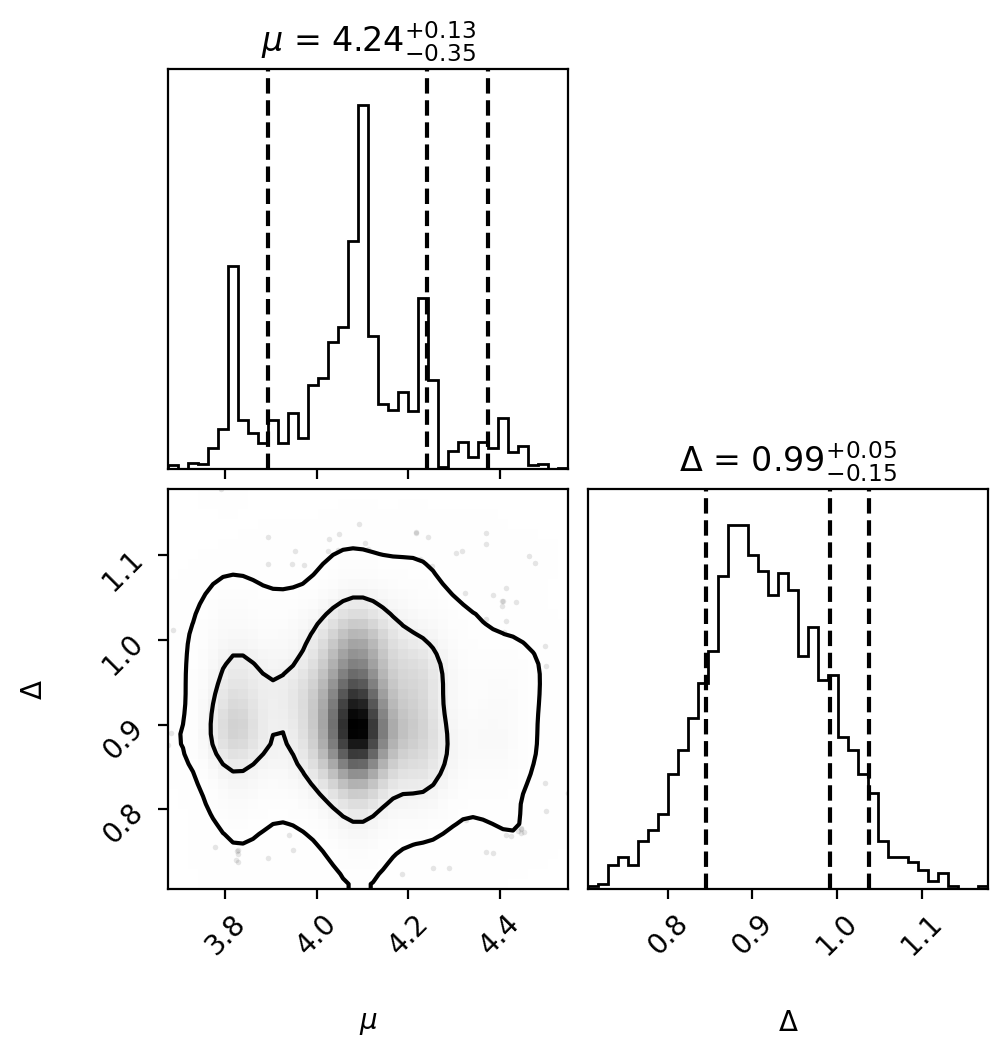

In [115]:
import corner

fit_vals = np.vstack([mu_vals, delt_vals]).T  

# Define labels for the axes
labels = [r"$\mu$", r"$\Delta$"]

fig = corner.corner(
    fit_vals, labels=labels, show_title=True, titles = [r"$\mu$", r"$\Delta$"], show_titles=True,  bins=40,  smooth=2.0, plot_density=True, plot_contours=True, 
    levels=[0.68, 0.95], quantiles=[0.16, 0.84, 0.95])

# Show the plot
plt.show()

In [119]:
import numdifftools as nd

H = nd.Hessian(f_laplace)(beta_laplac[0])
sigma_laplace = np.linalg.inv(H)**0.5

print(np.diag(sigma_laplace))

[0.11511675 0.08931347]


/var/folders/ls/sw9901md6hg56d8jmwp77nyr0000gp/T/ipykernel_35865/3078379954.py:4: RuntimeWarning: invalid value encountered in sqrt
  sigma_laplace = np.linalg.inv(H)**0.5
